# Ingest Digital Obstacle Data

We're going to get a dataset of aeronautical obstructions call the Digital Obstruction File. This is maintained by the US Federal Aviation Administratrion (FAA) and downloadable from [the FAA's DOF site](https://aeronav.faa.gov/Obst_Data/DAILY_DOF_CSV.ZIP). Take a look at [the FAQs](https://www.faa.gov/air_traffic/flight_info/aeronav/obst_data/doffaqs/).

## Download and check the data

In [1]:
!rm DAILY_DOF_CSV.zip DOF.CSV
!wget https://aeronav.faa.gov/Obst_Data/DAILY_DOF_CSV.zip
!unzip -o DAILY_DOF_CSV.ZIP

--2020-02-23 15:56:01--  https://aeronav.faa.gov/Obst_Data/DAILY_DOF_CSV.zip
Resolving aeronav.faa.gov (aeronav.faa.gov)... 155.178.201.160
Connecting to aeronav.faa.gov (aeronav.faa.gov)|155.178.201.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15056154 (14M) [application/x-zip-compressed]
Saving to: ‘DAILY_DOF_CSV.zip’

DAILY_DOF_CSV.zip   100%[===================>]  14.36M  1003KB/s    in 16s     

2020-02-23 15:56:17 (943 KB/s) - ‘DAILY_DOF_CSV.zip’ saved [15056154/15056154]

Archive:  DAILY_DOF_CSV.ZIP
  inflating: DOF.CSV                 


We can preview the data. Not using an encoding, or using something like `utf-8` chokes. Following [a tip about dealing with data that was exported from Excel](https://srinujammu.wordpress.com/2018/03/01/how-to-avoid-unicodedecodeerror-while-loading-data-into-dataset-in-python/), the use of `cp1252` seems to fix things.

In [2]:
import pandas as pd
import geopandas as gpd
dof = pd.read_csv('DOF.CSV', encoding="cp1252") #, nrows=30000)
print(dof.shape)

gdf = gpd.GeoDataFrame(dof, geometry=gpd.points_from_xy(dof.LONDEC, dof.LATDEC))
gdf.crs = "EPSG:4326"
gdf.crs
gdf.head()

(483167, 19)


,OAS,VERIFIED STATUS,COUNTRY,STATE,CITY,LATDEC,LONDEC,DMSLAT,DMSLON,TYPE,QUANTITY,AGL,AMSL,LIGHTING,ACCURACY,MARKING,FAA STUDY,ACTION,JDATE,geometry
0,01-001307,O,US,AL,DAUPHIN ISLAND,30.179167,-88.077500,30 10 45.00N,088 04 39.00W,RIG,1,236,236,R,5D,M,1990ASO01578OE,C,2014138,POINT (-88.07750 30.17917)
1,01-001459,O,US,AL,DAUPHIN ISLAND,30.188889,-88.120834,30 11 20.00N,088 07 15.00W,RIG,1,240,241,R,5D,M,1992ASO02229OE,C,2014138,POINT (-88.12083 30.18889)
2,01-001472,O,US,AL,FORT MORGAN,30.188889,-87.952778,30 11 20.00N,087 57 10.00W,STACK,1,193,193,R,5D,M,1992ASO02230OE,C,2014138,POINT (-87.95278 30.18889)
3,01-002558,O,US,AL,GULF SHORES,30.230278,-87.875000,30 13 49.00N,087 52 30.00W,BLDG,1,223,242,R,5D,N,1999ASO03256OE,C,2004005,POINT (-87.87500 30.23028)
4,01-002567,O,US,AL,GULF SHORES,30.230278,-87.873612,30 13 49.00N,087 52 25.00W,BLDG,1,223,242,R,5D,N,2000ASO03180OE,C,2004005,POINT (-87.87361 30.23028)


## Plot the data

There are more than 400,000 records so this can take around 15 seconds on my MacBook Air. Be patient! First we get some reference data.

In [3]:
countries_url = "https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_admin_0_countries.geojson"
countries = gpd.read_file(countries_url)
countries.head(3)

,scalerank,labelrank,sovereignt,sov_a3,adm0_dif,level,type,admin,adm0_a3,geou_dif,...,region_un,subregion,region_wb,name_len,long_len,abbrev_len,tiny,homepart,featureclass,geometry
0,1,3,Afghanistan,AFG,0,2,Sovereign country,Afghanistan,AFG,0,...,Asia,Southern Asia,South Asia,11,11,4,-99,1,Admin-0 country,"POLYGON ((61.21082 35.65007, 62.23065 35.27066..."
1,1,3,Angola,AGO,0,2,Sovereign country,Angola,AGO,0,...,Africa,Middle Africa,Sub-Saharan Africa,6,6,4,-99,1,Admin-0 country,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6..."
2,1,6,Albania,ALB,0,2,Sovereign country,Albania,ALB,0,...,Europe,Southern Europe,Europe & Central Asia,7,7,4,-99,1,Admin-0 country,"POLYGON ((20.59025 41.85540, 20.46318 41.51509..."


We can zoom into our area of primary interest (thanks to [StackOverflow](https://stackoverflow.com/a/46477574)) and plot the points. Again...lot of a data so be patient!

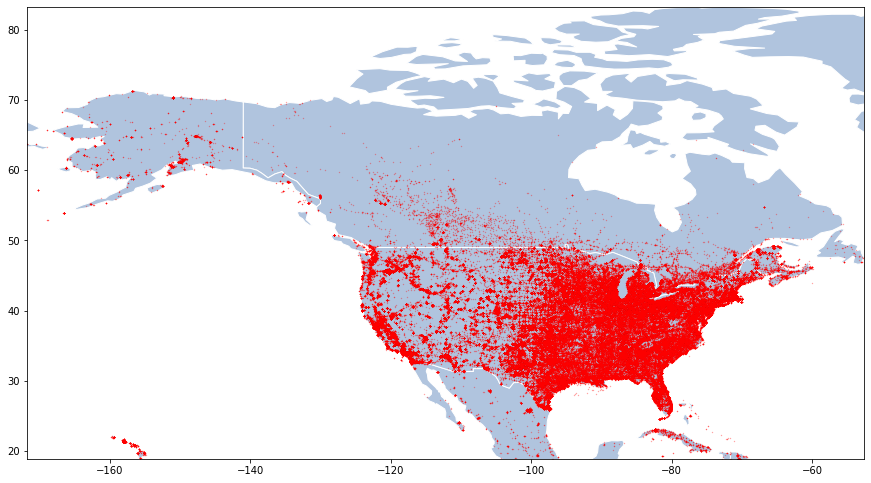

In [4]:
base = countries.plot(figsize=(15,10), color='lightsteelblue', edgecolor='white')
minx, miny, maxx, maxy = countries.query("region_wb=='North America'").total_bounds
base.set_xlim(minx, maxx)
base.set_ylim(miny, maxy)
ax = gdf.plot(ax=base, alpha=0.5, color='red', markersize=.1)

## Export and serve

So now we have the data and know how to make a map. We could easily script the creation of a little map for each location, and maybe put a more [recognizable base map](https://geopandas.org/gallery/plotting_basemap_background.html#add-background-tiles-to-plot) behind each one. But for now, let's dump the data. GeoJSON is a handy format to share spatial data but it's big (231MB), so let's save it in a different format: the GeoPackage:

In [3]:
!rm mn.geojson dof.gpkg dof.geojson
#gdf.to_file("dof.gpkg", layer='dof-daily', driver="GPKG")
gdf.query("STATE=='MN'").to_file("mn.geojson", driver="GeoJSON")
gdf.to_file("dof.geojson", driver="GeoJSON")
!ls -lh dof.gpkg

rm: mn.geojson: No such file or directory
rm: dof.gpkg: No such file or directory
rm: dof.geojson: No such file or directory
ls: dof.gpkg: No such file or directory


We're done. Now we could upload to the cloud for further processing. Look in the `maps` directory of this project to see a sample web page that shows the GeoJSON in an interesting way.